In [ ]:
!pip install cartopy

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import pandas as pd
import geopandas as gpd
from cartopy import crs

In [ ]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
type(world)

<ipython-input-21-bc8eadda4db1>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


geopandas.geodataframe.GeoDataFrame

In [ ]:

ae = crs.AzimuthalEquidistant()
aeproj4 = ae.proj4_init # Convert to`proj4` string/dict usable in gpd
world_ae = world.to_crs(aeproj4)
aea = crs.AlbersEqualArea()
aea

<Projected CRS: +proj=aea +ellps=WGS84 +lon_0=0.0 +lat_0=0.0 +x_0= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

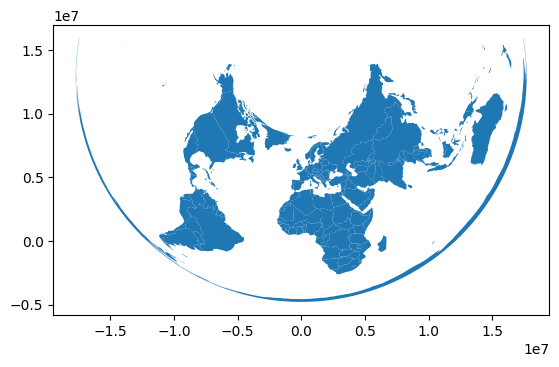

In [ ]:
aea_geo = [aea.project_geometry(ii, src_crs=ae)
for ii in world_ae['geometry'].values]

gpd.GeoDataFrame(world, geometry=aea_geo, crs=aea.proj4_init).plot();

c = pd.read_csv('/content/time_series_covid19_confirmed_global.csv')
c = c.rename(columns={'Country/Region': 'country'}).iloc[:, 1:]
len(c['country']) - len(set(c['country']))
cg = c.groupby('country')[c.columns[3:]].sum()
cg['Lat'] = c.groupby('country')['Lat'].mean()
cg['Long'] = c.groupby('country')['Long'].mean()
geo = gpd.points_from_xy(cg['Long'], cg['Lat'])
c_aea_geo = [aea.project_geometry(ii) for ii in geo]
cg = gpd.GeoDataFrame(cg, geometry=c_aea_geo, crs=aea.proj4_init)

In [ ]:
def covidworldmap(date):
  fig, ax = plt.subplots(figsize=(12, 10))
  # put the world map on an axis
  w = gpd.GeoDataFrame(world, geometry=aea_geo, crs=aea.proj4_init)
  w.plot(ax=ax, color='midnightblue', edgecolor='darkslategray')
  ax.set_facecolor('dimgray')
  mx = cg.iloc[:, :-3].max().max() # get max across data
  # set marker sizes, with a min marker size for cases > 1000
  msz = 500 * np.where(cg[date]-1000, np.maximum(cg[date]/mx, 0.001), 0)
  cg.plot(ax=ax, cmap='Wistia', markersize=msz, alpha=0.5)
  ax.set_xticks([]) # remove axis marks
  ax.set_yticks([]);

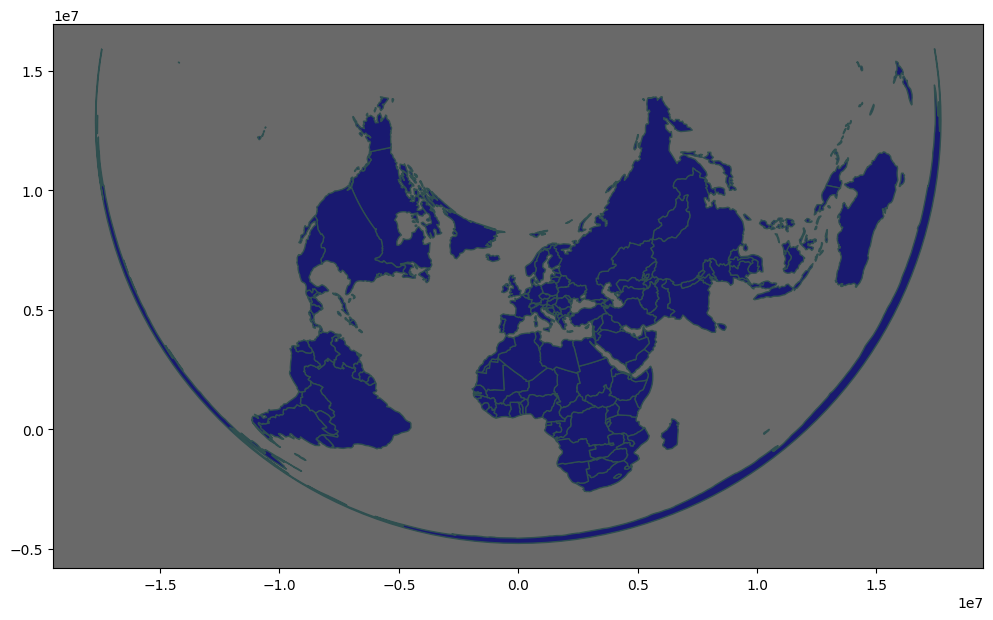

In [ ]:
!pip install celluloid

import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

# Create the initial plot
fig, ax = plt.subplots(figsize=(12, 10))
w = gpd.GeoDataFrame(world, geometry=aea_geo, crs=aea.proj4_init)
w.plot(ax=ax, color='midnightblue', edgecolor='darkslategray')
ax.set_facecolor('dimgray')
mx = cg.iloc[:, :-3].max().max() # get max across data
# covidworldmap('5/5/20')

camera = Camera(fig)

In [ ]:

# Generate animation frames
for date in cg.columns[:-3]:
    msz = 500 * np.where(cg[date]-1000, np.maximum(cg[date]/mx, 0.001), 0)
    w = gpd.GeoDataFrame(world, geometry=aea_geo, crs=aea.proj4_init)
    w.plot(ax=ax, color='midnightblue', edgecolor='darkslategray')
    ax.set_facecolor('dimgray')
    cg.plot(ax=ax, cmap='Wistia', markersize=msz, alpha=0.5)
    camera.snap()

# Create the animation
animation = camera.animate()

# Show the animation
animation.save('animation_covid_confirmed.mp4')